In [ ]:
import numpy as np
import imageio
import glob
from matplotlib import pyplot as plt
import time

In [ ]:
# Set seed so we always get the same random numbers
np.random.seed(42)

# Import Data

In [ ]:
!unzip MNIST.zip

In [ ]:
def load_mnist():
    # Loads the MNIST dataset from png images
    #
    # Return
    # X_train - Training input
    # Y_train - Training output (one-hot encoded)
    # X_test - Test input
    # Y_test - Test output (one-hot encoded)
    #
    # Each of them uses rows as data point dimension. Remember to transpose the output if you use columns for data point dimension

    NUM_LABELS = 10
    # create list of image objects
    test_images = []
    test_labels = []

    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Test/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]
            letter[label] = 1
            test_labels.append(letter)

    # create list of image objects
    train_images = []
    train_labels = []

    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Train/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]
            letter[label] = 1
            train_labels.append(letter)

    X_train= np.array(train_images).reshape(-1,784)/255.0
    Y_train= np.array(train_labels)
    X_test= np.array(test_images).reshape(-1,784)/255.0
    Y_test= np.array(test_labels)

    return X_train, Y_train, X_test, Y_test

In [ ]:
X_train, Y_train, X_test, Y_test = load_mnist()

/tmp/ipython-input-2084685998.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
/tmp/ipython-input-2084685998.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


# Exercise 1

## Initialization

In [ ]:
def init_params(K, D):
  # K = Number of hidden layers
  # D = Number of neurons per layer

  # Input layer dimension: number of pixels
  D_i = 784
  # Output layer dimension: number of digits
  D_o = 10

  # Make empty lists
  all_weights = [None] * (K+1)
  all_biases = [None] * (K+1)

  # Create input and output layer with He initialization
  if K==0:
      all_weights[0] = np.random.normal(loc=0, scale=np.sqrt(2/D_i), size=(D_o, D_i))
  else:
      all_weights[0] = np.random.normal(loc=0, scale=np.sqrt(2/D_i), size=(D, D_i))
      all_weights[-1] = np.random.normal(loc=0, scale=np.sqrt(2/D), size=(D_o, D))
      all_biases[0] = np.zeros((D,1))

  all_biases[-1]= np.zeros((D_o,1))

  # Create intermediate layers
  for layer in range(1,K):
      all_weights[layer] = np.random.normal(loc=0, scale=np.sqrt(2/D), size=(D,D))
      all_biases[layer] = np.zeros((D,1))
  return all_weights, all_biases

## Activation Function

In [ ]:
# Define the Rectified Linear Unit (ReLU) function
def ReLU(x):
    activation = x.clip(0.0)
    return activation

# We'll need the indicator function in the backwards pass, since this is the derivative of the ReLU function.
def indicator_function(x):
    x_in = np.array(x)
    x_in[x_in>0] = 1
    x_in[x_in<=0] = 0
    return x_in

In [ ]:
# Define sigmoid function
def sigmoid(x):
  activation = 1/(1+np.exp(-x))
  return activation

# Derivative of sigmoid for backward pass
def dl_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

## Forward Propagation

In [ ]:
def forward_pass(net_input, all_weights, all_biases):
    net_input = net_input.T
    # Retrieve number of layers
    K = len(all_weights) -1

    # We'll store the pre-activations at each layer in a list "all_f"
    # and the activations in a second list "all_h".
    all_f = [None] * (K+1)
    all_h = [None] * (K+1)

    #For convenience, we'll set all_h[0] to be the input, and all_f[K] will be the output
    all_h[0] = net_input

    # Run through the layers, calculating all_f[0...K-1] and all_h[1...K]
    for layer in range(K):
        # Update preactivations and activations at this layer
        all_f[layer] = np.matmul(all_weights[layer], all_h[layer]) + all_biases[layer]
        all_h[layer+1] = sigmoid(all_f[layer])
    # Compute the output from the last hidden layer
    all_f[K] = np.matmul(all_weights[-1], all_h[-1]) + all_biases[-1]

    # Retrieve the output
    net_output = all_f[K]

    return net_output, all_f, all_h

## Softmax and cost

In [ ]:
# Softmax activation function for final prediction

def softmax(logits):
  logits = logits.T
  exp_logits = np.exp(logits)
  sum_exp_logits = np.sum(exp_logits, axis=1, keepdims=True)
  return exp_logits/sum_exp_logits

In [ ]:
def compute_cost(net_output, y):
    I = y.T.shape[1]  # Number of data points if data points as columns
    return np.sum((np.log(np.sum(np.exp(net_output.T), axis=1))-np.sum((y*net_output.T), axis=1)))/I

def d_cost_d_output(net_output, y):
    I = y.T.shape[1] # Number of data points if data points as columns
    return (softmax(net_output).T-y.T)/I

## Backward propagation

In [ ]:
# Main backward pass routine
def backward_pass(all_weights, all_biases, all_f, all_h, K, y):
    # We'll store the derivatives dl_dweights and dl_dbiases in lists as well
    all_dl_dweights = [None] * (K+1)
    all_dl_dbiases = [None] * (K+1)
    # And we'll store the derivatives of the cost with respect to the activation and preactivations in lists
    all_dl_df = [None] * (K+1)
    all_dl_dh = [None] * (K+1)
    # Again for convenience we'll stick with the convention that all_h[0] is the net input and all_f[k] in the net output

    # Compute derivatives of the cost with respect to the network output
    all_dl_df[K] = np.array(d_cost_d_output(all_f[K],y))

    # Now work backwards through the network from layer K to layer 0
    layer_range = range(K, -1 , -1)
    for layer in layer_range:
        # Calculate the derivatives of the cost with respect to the biases at layer from all_dl_df[layer]
        all_dl_dbiases[layer] = np.sum(all_dl_df[layer], axis=-1, keepdims=1)
        # Calculate the derivatives of the cost with respect to the weights at layer from all_dl_df[layer] and all_h[layer]
        all_dl_dweights[layer] = np.matmul(all_dl_df[layer], all_h[layer].T)
        # Calculate the derivatives of the cost with respect to the activations from weight and derivatives of next preactivations (second part of last line of eq 7.24, pdf version: eq 7.25)
        all_dl_dh[layer] = np.matmul(all_weights[layer].T,all_dl_df[layer])

        if layer > 0:
            # Calculate the derivatives of the cost with respect to the pre-activation f
            all_dl_df[layer-1] = dl_sigmoid(all_f[layer-1])*all_dl_dh[layer]

    return all_dl_dweights, all_dl_dbiases

## Take a step

In [ ]:
# weights = weights - lr*gradients
def update_parameters(all_weights, all_biases, all_dl_dbiases, all_dl_dweights, lr):
  lr_dl_dweights = [dl_weights*lr for dl_weights in all_dl_dweights]
  lr_dl_dbiases = [dl_bias*lr for dl_bias in all_dl_dbiases]
  all_weights = [weights - lr_weights for weights, lr_weights in zip(all_weights, lr_dl_dweights)]
  all_biases = [biases - lr_biases for biases, lr_biases in zip(all_biases, lr_dl_dbiases)]

  return all_weights, all_biases

## Predict

In [ ]:
# compute forward pass, softmax, and compare the highest value with the true label
def predict(x_test, y_test, final_weights, final_biases):
  correct = 0
  logits,_,_ = forward_pass(x_test, final_weights, final_biases)
  preds = softmax(logits)
  pred_classes = [int(np.where(pred==max(pred))[0]) for pred in preds]
  true_classes = [int(np.where(y==1)[0]) for y in y_test]
  correct_preds = [pred == true_class for (pred, true_class) in zip(pred_classes, true_classes)]
  acc = sum(correct_preds)/len(correct_preds)
  cost = compute_cost(logits, y_test)
  return acc, cost

## Mini-batch generation

In [ ]:
# apply a random permutation to the dataset and divide it based on the batch size

def random_mini_batches(X_train, Y_train, batch_size=32):
  p = np.random.permutation(len(X_train))
  X_train, Y_train = X_train[p], Y_train[p]
  num_batches = len(X_train)/batch_size
  x_mini, y_mini = np.array_split(X_train, num_batches), np.array_split(Y_train, num_batches)
  return x_mini, y_mini

## Model Training

In [ ]:
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate, num_epochs, elapsed):
    # Plot training curves in a format recomended for Hand-in assignment 1 and 2
    #
    # Input
    # title - title for the plot
    # train_costs - Array of training costs
    # test_costs - Array of test costs
    # train_accuracies - Array of training accuracies
    # test_accuracies - Array of test accuracies
    # batch_size - batch size for training data used during training
    # num_epochs - Number of epochs used during training
    # elapsed - Time elapsed in seconds during training

    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    elapsed_min, elapsed_sec = divmod(elapsed, 60)
    sub = f'|  Batch size:{batch_size}  |  Learning rate:{learning_rate} | Number of Epochs:{num_epochs} | Training time: {elapsed_min:.0f} min {elapsed_sec:.1f} sec |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    x = np.array(range(1, len(train_costs)+1))*num_epochs/len(train_costs)
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)

In [ ]:
# define the model based on the number of layers and neurons in each of them

def model(num_layers, num_neurons):
  return [num_layers, num_neurons]

In [ ]:
# train model and store the losses and the accuracies until convergence

def train_model(x_train, y_train, X_test, Y_test, model, num_epochs, lr=0.01, batch_size=32):
  best_cost = np.inf
  best_epoch_passed = 0
  train_costs, test_costs, train_accuracies, test_accuracies = [], [], [], []
  [K, D]= model
  # initialize weights
  all_weights, all_biases = init_params(K,D)
  start = time.time()
  # loop over the epochs
  for i in range(num_epochs):
    #generate different mini batches for each epoch
    x_mini, y_mini = random_mini_batches(x_train, y_train, batch_size)
    M = len(y_mini)
    # loop over the batches
    for m in range(M):
      net_output, all_f, all_h = forward_pass(x_mini[m], all_weights, all_biases)
      L = compute_cost(net_output, y_mini[m])
      all_dl_dweights, all_dl_dbiases = backward_pass(all_weights, all_biases, all_f, all_h, K, y_mini[m])
      all_weights, all_biases = update_parameters(all_weights, all_biases, all_dl_dbiases, all_dl_dweights, lr)

    # store losses and accuracies
    train_costs.append(L)
    preds = softmax(net_output)
    pred_classes = [int(np.where(pred==max(pred))[0]) for pred in preds]
    true_classes = [int(np.where(y==1)[0]) for y in y_mini[m]]
    correct_preds = [pred == true_class for (pred, true_class) in zip(pred_classes, true_classes)]
    train_acc = sum(correct_preds)/len(correct_preds)
    epoch = i+1
    print(f"Epoch: {i+1}, Loss: {L}")
    train_accuracies.append(train_acc)

    test_accuracy, test_cost = predict(X_test, Y_test, all_weights, all_biases)
    test_costs.append(test_cost)
    test_accuracies.append(test_accuracy)

    # check for early stopping
    if test_cost < best_cost:
      best_cost = test_cost
      best_epoch_passed = 0
    else:
      best_epoch_passed += 1
    if best_epoch_passed >= 5:
      break
  end = time.time()
  elapsed = end-start
  return all_weights, all_biases, train_costs, train_accuracies, test_costs, test_accuracies, elapsed, epoch

# Exercise 2

In [ ]:
num_epochs = 100
lr = 0.01
batch_size = 32

In [ ]:
# train linear model
final_weights, final_biases, train_costs, train_accuracies, test_costs, test_accuracies, elapsed, final_epoch = train_model(X_train, Y_train, X_test, Y_test, model(0,0), num_epochs, lr, batch_size)

/tmp/ipython-input-2543199792.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_classes = [int(np.where(pred==max(pred))[0]) for pred in preds]
/tmp/ipython-input-2543199792.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_classes = [int(np.where(y==1)[0]) for y in y_mini[m]]
/tmp/ipython-input-745136130.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_classes = [int(np.where(pred==max(pred))[0]) for pred in preds]
/tmp/ipython-input-745136

Epoch: 1, Loss: 0.48436986695082224
Epoch: 2, Loss: 0.5070915010937695
Epoch: 3, Loss: 0.6123287534048952
Epoch: 4, Loss: 0.4292400995755786
Epoch: 5, Loss: 0.3382809132291607
Epoch: 6, Loss: 0.39677938134665425
Epoch: 7, Loss: 0.4112155228911041
Epoch: 8, Loss: 0.29252948403403545
Epoch: 9, Loss: 0.15623059484328644
Epoch: 10, Loss: 0.40484012455541485
Epoch: 11, Loss: 0.30122451031138486
Epoch: 12, Loss: 0.22138707086612386
Epoch: 13, Loss: 0.30595924908561517
Epoch: 14, Loss: 0.14810039622615723
Epoch: 15, Loss: 0.20509003441259974
Epoch: 16, Loss: 0.42049221033303785
Epoch: 17, Loss: 0.19089773837688864
Epoch: 18, Loss: 0.3185465227994819
Epoch: 19, Loss: 0.20900639878209867
Epoch: 20, Loss: 0.4933532816927282
Epoch: 21, Loss: 0.37047763690939906
Epoch: 22, Loss: 0.25666947423280045
Epoch: 23, Loss: 0.2609361349161762
Epoch: 24, Loss: 0.21900190920911583
Epoch: 25, Loss: 0.1264006286436346
Epoch: 26, Loss: 0.3425047332101401
Epoch: 27, Loss: 0.28309050317802587
Epoch: 28, Loss: 0.1

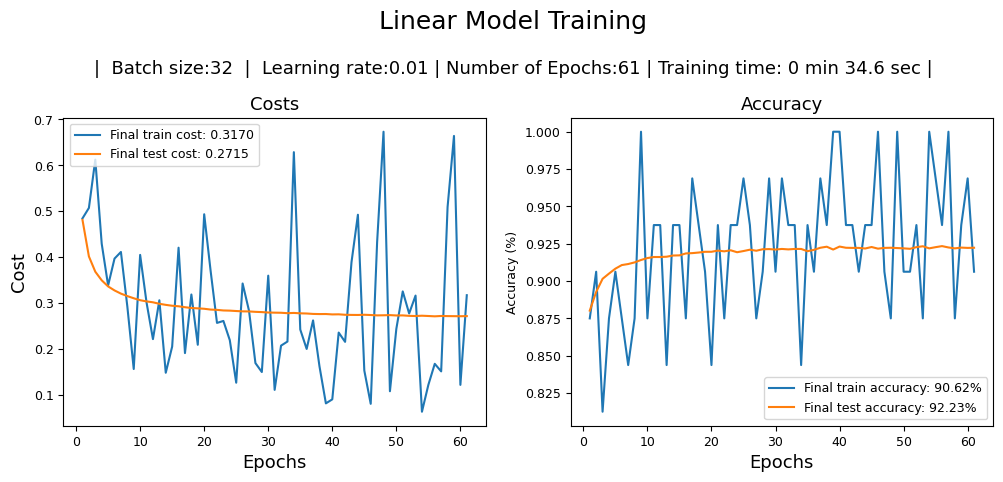

In [ ]:
title = "Linear Model Training"
training_curve_plot(title, train_costs, test_costs, train_accuracies, test_accuracies, batch_size, lr, final_epoch, elapsed)

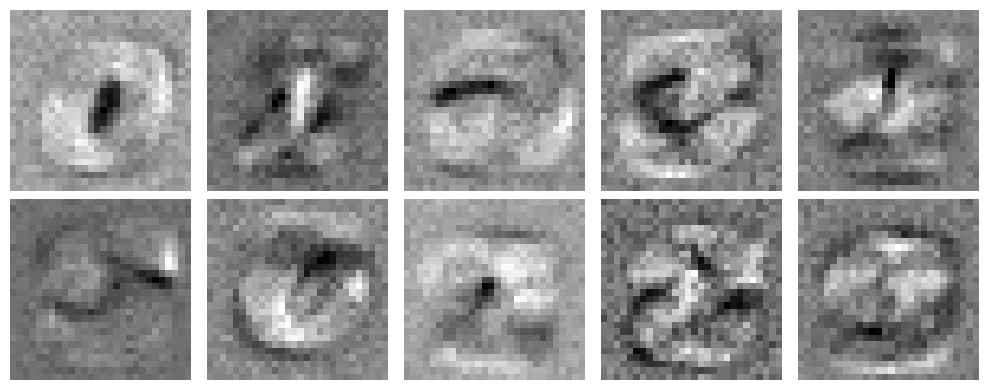

In [ ]:
# plot weight matrices

data = [final_weights[0][i].reshape(28, 28) for i in range(10)]
fig, axlist = plt.subplots(2, 5, figsize=(10, 4))
axlist = axlist.flatten()
for img, ax in zip(data, axlist):
    ax.imshow(img, cmap='binary_r')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Exercise 3

### ReLU

In [ ]:
num_epochs_relu = 100

In [ ]:
# train fnn with ReLU
final_weights_relu, final_biases_relu, train_costs_relu, train_accuracies_relu, test_costs_relu, test_accuracies_relu, elapsed_relu, final_epoch_relu = train_model(X_train, Y_train, X_test, Y_test, model(4,120), num_epochs_relu, lr, batch_size)

/tmp/ipython-input-2543199792.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_classes = [int(np.where(pred==max(pred))[0]) for pred in preds]
/tmp/ipython-input-2543199792.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_classes = [int(np.where(y==1)[0]) for y in y_mini[m]]
/tmp/ipython-input-745136130.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_classes = [int(np.where(pred==max(pred))[0]) for pred in preds]


Epoch: 1, Loss: 0.1316777595344224


/tmp/ipython-input-745136130.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_classes = [int(np.where(y==1)[0]) for y in y_test]


Epoch: 2, Loss: 0.28200089669055595
Epoch: 3, Loss: 0.2605075569864669
Epoch: 4, Loss: 0.22857476957068554
Epoch: 5, Loss: 0.006651320263637961
Epoch: 6, Loss: 0.08955456355032107
Epoch: 7, Loss: 0.10183752892085228
Epoch: 8, Loss: 0.10819156108835273
Epoch: 9, Loss: 0.0666938239047591
Epoch: 10, Loss: 0.00427392209005914
Epoch: 11, Loss: 0.0958050965269197
Epoch: 12, Loss: 0.018102452785218437
Epoch: 13, Loss: 0.030522557166100417
Epoch: 14, Loss: 0.1165069838735201
Epoch: 15, Loss: 0.04076694625032011
Epoch: 16, Loss: 0.002936731283246813
Epoch: 17, Loss: 0.010286794289595003
Epoch: 18, Loss: 0.018316325254648602
Epoch: 19, Loss: 0.022651620147183055
Epoch: 20, Loss: 0.05005081409117362
Epoch: 21, Loss: 0.03721639164788082
Epoch: 22, Loss: 0.0069632085449346515


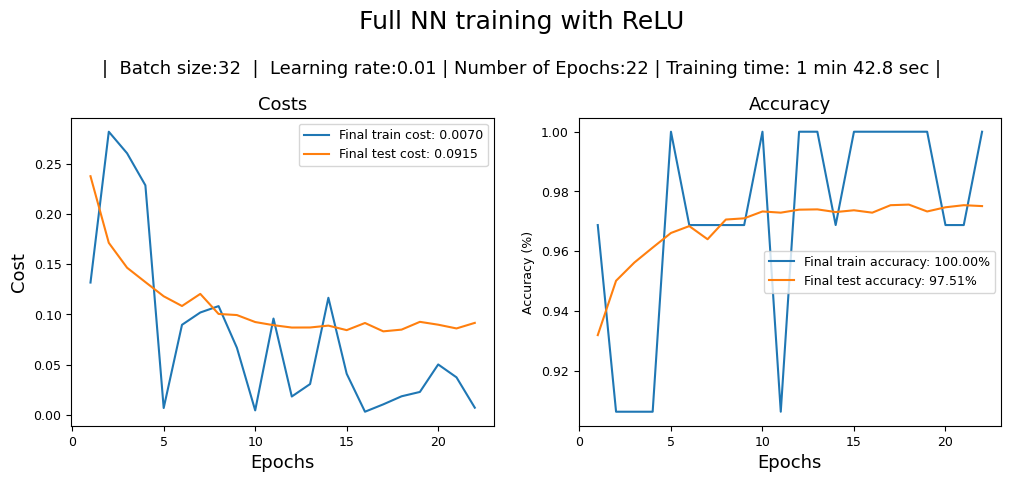

In [ ]:
title = "Full NN training with ReLU"
training_curve_plot(title, train_costs_relu, test_costs_relu, train_accuracies_relu, test_accuracies_relu, batch_size, lr, final_epoch_relu, elapsed_relu)

### Sigmoid

In [ ]:
num_epochs_sigm = 200

In [ ]:
# train fnn with sigmoid
final_weights_sigm, final_biases_sigm, train_costs_sigm, train_accuracies_sigm, test_costs_sigm, test_accuracies_sigm, elapsed_sigm, final_epoch_sigm = train_model(X_train, Y_train, X_test, Y_test, model(4,120), num_epochs_sigm, lr, batch_size)

/tmp/ipython-input-2543199792.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_classes = [int(np.where(pred==max(pred))[0]) for pred in preds]
/tmp/ipython-input-2543199792.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_classes = [int(np.where(y==1)[0]) for y in y_mini[m]]
/tmp/ipython-input-745136130.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_classes = [int(np.where(pred==max(pred))[0]) for pred in preds]
/tmp/ipython-input-745136

Epoch: 1, Loss: 2.327039924104243
Epoch: 2, Loss: 2.3353212004240866
Epoch: 3, Loss: 2.2987481842167616
Epoch: 4, Loss: 2.281989985390933
Epoch: 5, Loss: 2.292069673446237
Epoch: 6, Loss: 2.0347144954457717
Epoch: 7, Loss: 1.709456415443544
Epoch: 8, Loss: 1.385626172430244
Epoch: 9, Loss: 1.3156974326317803
Epoch: 10, Loss: 0.9158004498473449
Epoch: 11, Loss: 1.165865688547107
Epoch: 12, Loss: 0.9376926007183134
Epoch: 13, Loss: 0.5166446932124761
Epoch: 14, Loss: 0.46932591157293635
Epoch: 15, Loss: 0.426998976593684
Epoch: 16, Loss: 0.33441290681811214
Epoch: 17, Loss: 0.3956604593537286
Epoch: 18, Loss: 0.6584644788140377
Epoch: 19, Loss: 0.7767477752948666
Epoch: 20, Loss: 0.3233562997975865
Epoch: 21, Loss: 0.3966252177126027
Epoch: 22, Loss: 0.46101424403346936
Epoch: 23, Loss: 0.4353680399499371
Epoch: 24, Loss: 0.6083275414785075
Epoch: 25, Loss: 0.5077829601021873
Epoch: 26, Loss: 0.3292468942272983
Epoch: 27, Loss: 0.26676620493805964
Epoch: 28, Loss: 0.3192730221321639
Epoc

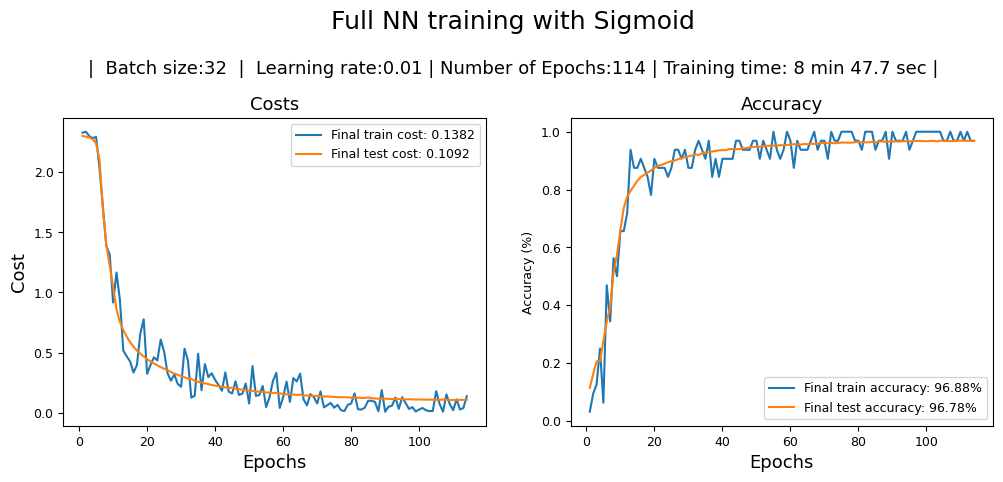

In [ ]:
title = "Full NN training with Sigmoid"
training_curve_plot(title, train_costs_sigm, test_costs_sigm, train_accuracies_sigm, test_accuracies_sigm, batch_size, lr, final_epoch_sigm, elapsed_sigm)